In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Flatten, Dense, Dropout, Rescaling, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

from PIL import Image
from pillow_heif import register_heif_opener


# ensure that any edits to libraries you make are reloaded here automatically
%reload_ext autoreload
%autoreload 2
%matplotlib inline


c:\Users\viola\anaconda3\envs\opencv-env\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Testing with Few Samples

### Testing Prediction

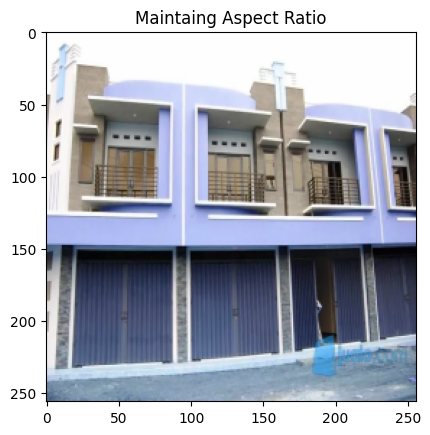

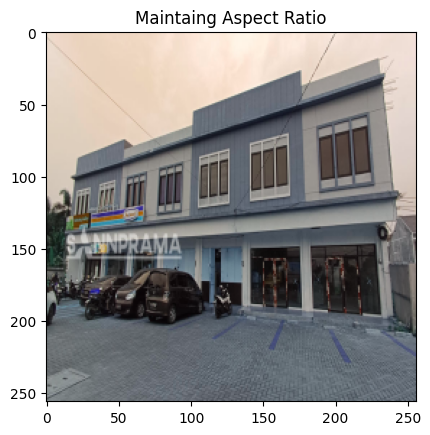

In [3]:
img1 = cv2.imread("ruko-01.jpg")
img2 = cv2.imread("ruko-02.jpg",cv2.IMREAD_COLOR)

#Step 1 : Resize Image to 800x600 size 

width = 256
height = width
dim = (width,height)

resize_dim1 = cv2.resize(img1,dsize=dim,interpolation=cv2.INTER_AREA)
resize_dim2 = cv2.resize(img2,dsize=dim,interpolation=cv2.INTER_AREA)

plt.imshow(resize_dim1,cmap="gray");plt.title("Maintaing Aspect Ratio");plt.show()
plt.imshow(resize_dim2,cmap="gray");plt.title("Maintaing Aspect Ratio");plt.show()


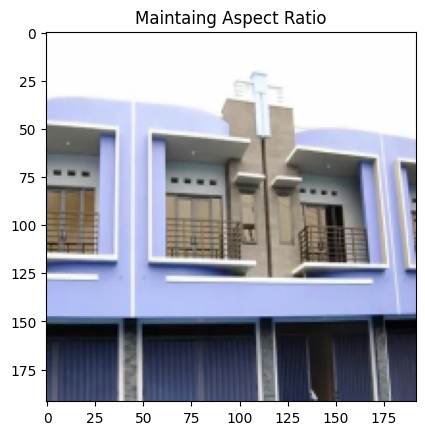

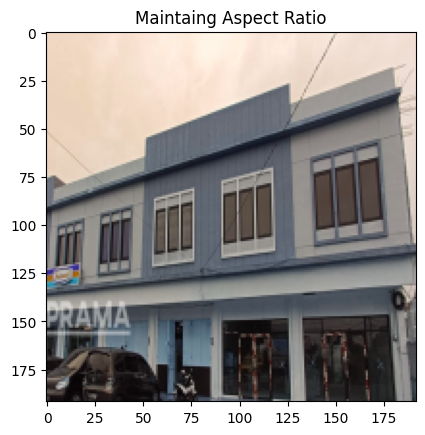

In [4]:
resize_cropped_dim1 = resize_dim1[0:192,50:242]
resize_cropped_dim2 = resize_dim2[0:192,50:242]

plt.imshow(resize_cropped_dim1,cmap="gray");plt.title("Maintaing Aspect Ratio");plt.show()
plt.imshow(resize_cropped_dim2,cmap="gray");plt.title("Maintaing Aspect Ratio");plt.show()

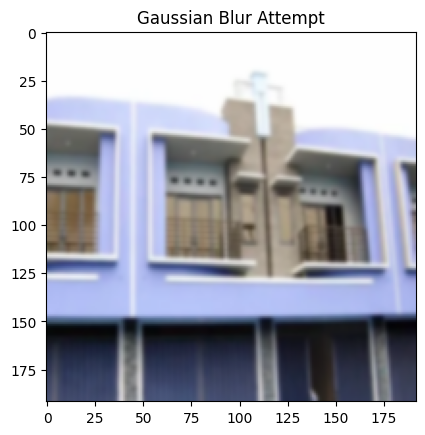

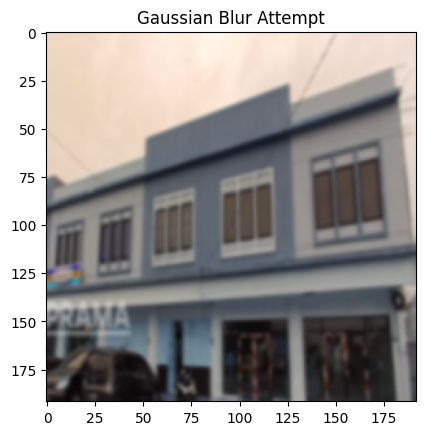

In [5]:
#Step 2 : Gaussian Blur to hide details 

blurred1 = cv2.GaussianBlur(src=resize_cropped_dim1, ksize=(5, 5), sigmaX=1) 
blurred2 = cv2.GaussianBlur(src=resize_cropped_dim2, ksize=(5, 5), sigmaX=1 )

plt.imshow(blurred1,cmap="gray");plt.title("Gaussian Blur Attempt");plt.show()
plt.imshow(blurred2,cmap="gray");plt.title("Gaussian Blur Attempt");plt.show()


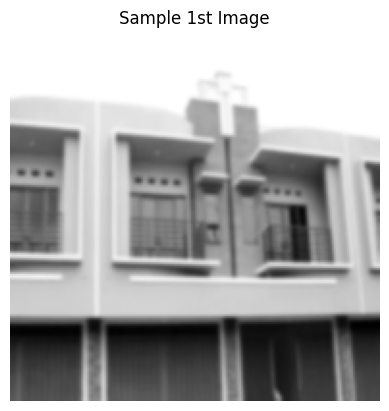

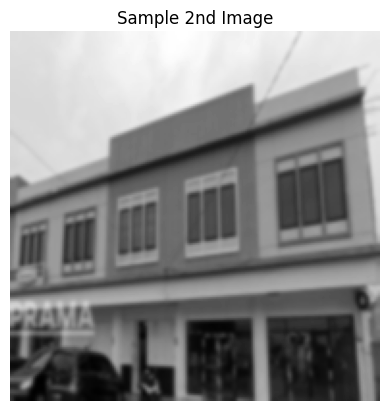

In [6]:
img_rgb1 = cv2.cvtColor(blurred1,cv2.COLOR_BGR2GRAY)
img_rgb2 = cv2.cvtColor(blurred2,cv2.COLOR_BGR2GRAY)

plt.axis("off");plt.imshow(img_rgb1,cmap="gray");plt.title("Sample 1st Image");plt.show()
plt.axis("off");plt.imshow(img_rgb2,cmap="gray");plt.title("Sample 2nd Image")
plt.show()

79
158


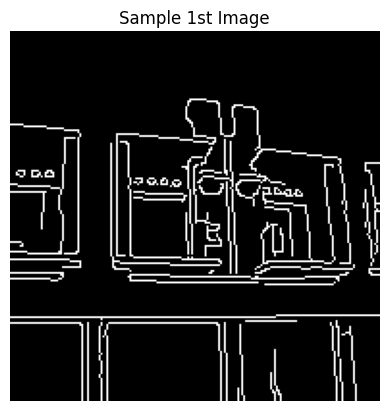

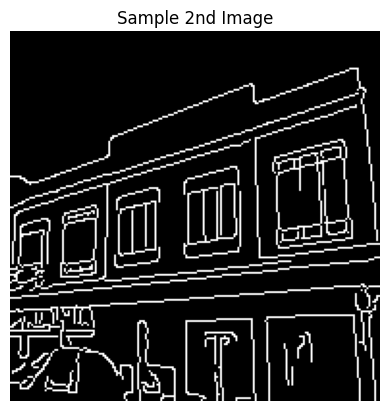

In [7]:
#Step 3 : Apply Canny Function to Find Edges

v = np.median(blurred2)
sigma = 0.33
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
aperture_size = 3

img_edge_l2_1 = cv2.Canny(blurred1,lower,upper,apertureSize=aperture_size,L2gradient=True)
img_edge_l2_2 = cv2.Canny(blurred2,lower,upper,apertureSize=aperture_size,L2gradient=True)
print(lower)
print(upper)
plt.axis("off");plt.imshow(img_edge_l2_1,cmap="gray");plt.title("Sample 1st Image");plt.show()
plt.axis("off");plt.imshow(img_edge_l2_2,cmap="gray");plt.title("Sample 2nd Image")
plt.show()

#Use cv2 to make it grayscale
# cv2.imshow("Canny Edge",img_edge_l2_2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

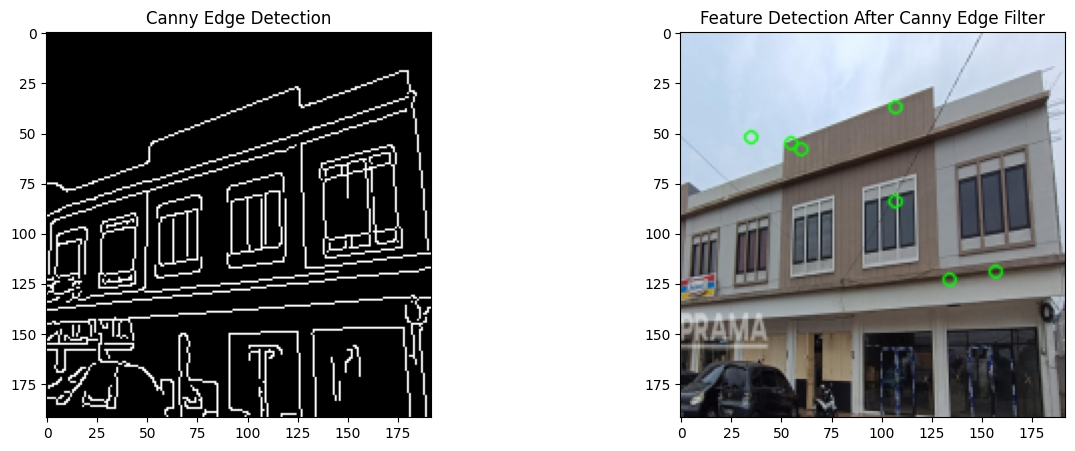

In [8]:
orb = cv2.ORB_create()
# Mask the original image with the Canny edges
keypoints1, descriptors1 = orb.detectAndCompute(img_rgb1, mask=img_edge_l2_1)
keypoints2, descriptors2 = orb.detectAndCompute(img_rgb2, mask=img_edge_l2_2)

# Draw the keypoints on the original image
image1_display = cv2.drawKeypoints(resize_cropped_dim1, keypoints1, None, color=(255, 0, 0), flags=0)
image2_display = cv2.drawKeypoints(resize_cropped_dim2, keypoints1, None, color=(0, 255, 0), flags=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Canny Edge Detection")
plt.imshow(img_edge_l2_2, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Feature Detection After Canny Edge Filter")
plt.imshow(cv2.cvtColor(image2_display, cv2.COLOR_BGR2RGB))
plt.show()

In [34]:
lines = cv2.HoughLinesP(img_edge_l2_2, 1, np.pi/180,70,minLineLength=20,maxLineGap=5)
#Create black empty canvas
line_image = np.zeros_like(resize_cropped_dim1) 
# Draw lines on the image
for line in lines:
   x1, y1, x2, y2 = line[0]
   cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 1,cv2.LINE_AA)
# Show result
print("Line Detection using Hough Transform")
cv2.imshow('lanes',line_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Line Detection using Hough Transform


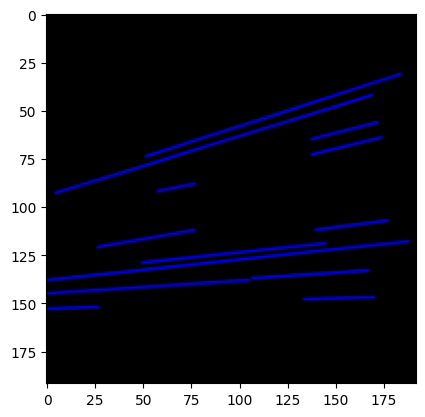

In [35]:
plt.imshow(line_image)

## Test over Loop

### Start Preprocess Image and DataFrame

In [2]:
#CONVERT HEIC FORMAT IMAGE TO JPG
def heic_tp_jpg(img_path):
    # Register HEIC support
    register_heif_opener()
    heic_image = Image.open(img_path)
    # Convert to RGB and save as JPG
    jpg_path = img_path + '.jpg'
    heic_image.convert('RGB').save(jpg_path)



In [45]:
# Create function to crop area of interest and resize it later

def resize_image(file,image_width):
    img = cv2.imread(file,cv2.IMREAD_COLOR)
    #Rescale to inputted size 
    width = image_width
    height = image_width
    dim = (width,height)
    resize_image = cv2.resize(img,dsize=dim,interpolation=cv2.INTER_AREA)
    #Crop the resized image the get the area of interest
    x1 = 0
    x2 = int(image_width*0.75)
    y1 = 50
    y2 = int(image_width-(y1*0.2))
    resize_cropped = resize_image[x1:x2,y1:y2]
    # Resize again to gain N x N size
    width2 = int(x2*0.67)
    height2 = width2
    cropped_dim = (width2,height2)
    resize_cropped_image = cv2.resize(resize_cropped,dsize=cropped_dim,interpolation=cv2.INTER_AREA)

    output_image = resize_cropped_image.copy()
    return output_image

In [42]:
def preprocess_image(image_path):
    #Convert image to grayscale colour
    gray = cv2.cvtColor(image_path,cv2.COLOR_BGR2GRAY)
    #Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, ksize=(3, 3), sigmaX=1) 

    #Apply Canny Edge 
    v = np.median(blurred)
    sigma = 0.33
    lower = int(max(50, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    aperture_size = 3
    img_edge = cv2.Canny(blurred,lower,upper,apertureSize=aperture_size,L2gradient=True)

    return img_edge

#### Create Preprocessed Image

In [46]:
import os
directory = ("real_dataset/")
new_directory = "preprocess"

images = []
labels = []

valid_folder = ["Apartment","Penthouse","Ruko","Rumah 1 lantai"]
for class_dir in os.listdir(directory):
    #Verify if subfolder name is included in valid_folder list
    if class_dir in valid_folder:
        class_path = os.path.join(directory, class_dir)
        #Class_path value is "real-dataset/BuildingType"

        #Verify if class_path is a directory and not empty
        if os.path.isdir(class_path) and os.listdir(class_path):
            for idx,img_name in enumerate(os.listdir(class_path)):
                img_path = os.path.join(class_path, img_name) #Format : real_dataset/building-type/file name
                #Convert to JPG File becuase HEIC cannot be processed immediately
                if img_path.lower().endswith(".heic"):
                    heic_tp_jpg(img_path)

                # #Preprocess Image until Image is given Hough Line
                resized_images = resize_image(img_path,256)
                hough_canny_image = preprocess_image(resized_images)

                #Save Preproccsed Image to new directory
                filename = f"{class_dir}-{idx+1}.png"
                new_folder = f"{new_directory}/{class_dir}"
                os.makedirs(new_folder, exist_ok=True)
                new_path = os.path.join(new_folder, filename)
                cv2.imwrite(new_path, hough_canny_image)



#### With Tensorflow Keras Library

In [47]:
dataset_path = ("preprocess/")
output_path = ("final_preprocess")
print(os.path.exists(dataset_path)) 


True


In [86]:
import random
import shutil
from sklearn.model_selection import train_test_split

classes = ["Apartment", "Penthouse", "Ruko", "Rumah 1 lantai"]  # Specify valid classes

# Create directories for train/validation split
train_dir = os.path.join(output_path, "train")
val_dir = os.path.join(output_path, "validation")

# Ensure directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        # Get all files in the class directory
        files = os.listdir(class_path)
        files = [os.path.join(class_path, f) for f in files if f.lower().endswith(('jpg', 'jpeg', 'png', 'heic'))]

        # Split files into training and validation sets (80-20 split)
        train_files, val_files = train_test_split(files, test_size=0.25, random_state=42)

        # Create subdirectories for this class in train/val folders
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        # Copy files to respective directories
        for file in train_files:
            shutil.copy(file, train_class_dir)
        for file in val_files:
            shutil.copy(file, val_class_dir)


In [87]:
#Load dataset from directory and split to training and validation set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              image_size=(128, 128),
                                                              seed=0,
                                                              batch_size=32,
                                                              shuffle=True)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                              image_size=(128, 128),
                                                              seed=0,
                                                              batch_size=32,
                                                              shuffle=True) 

Found 552 files belonging to 4 classes.
Found 260 files belonging to 4 classes.


In [88]:
class_name = train_ds.class_names
print(class_name)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['Apartment', 'Penthouse', 'Ruko', 'Rumah 1 lantai']
(32, 128, 128, 3)
(32,)


In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply augmentation to training data
train_augmented = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 552 images belonging to 4 classes.


<Figure size 1000x1000 with 0 Axes>

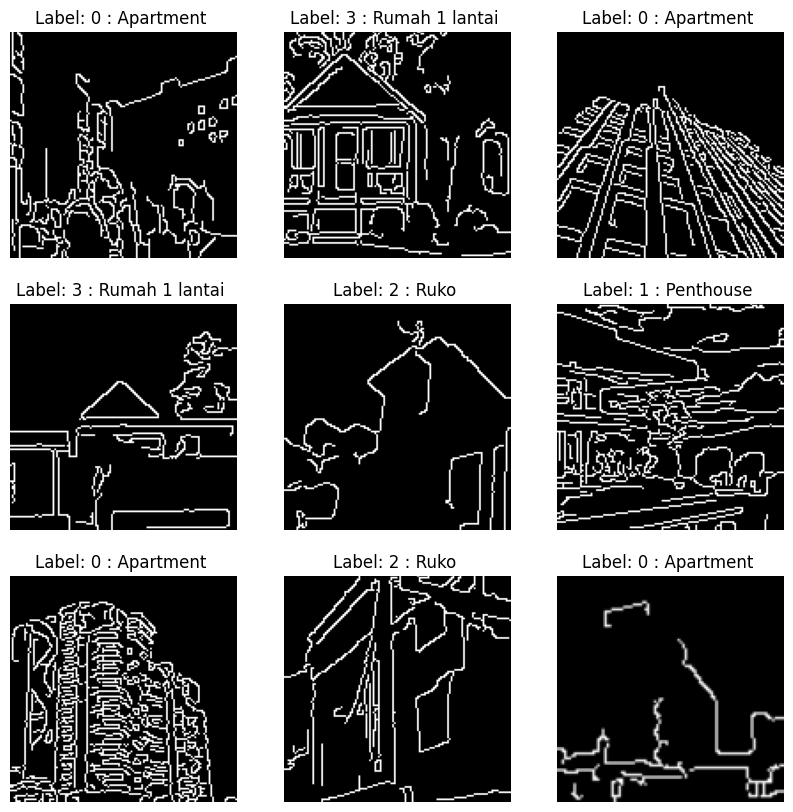

In [90]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()} : {class_name[labels[i].numpy()]} ")
        plt.axis("off")


In [91]:
# Normalize and prefetch for performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(250).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Define ANN Model with Keras Module

In [92]:
num_classes = len(class_name)
model = Sequential([
        Rescaling(1./255, input_shape=(128, 128, 3)),
        Flatten(),

        Dense(512,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(256,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.05)),
        BatchNormalization(),
        Dropout(0.3),
        BatchNormalization(),

        Dense(num_classes,activation="softmax"),
    ])
    
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
    
summary = model.summary()



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,335,172 (96.65 MB)

 Trainable params: 25,333,124 (96.64 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [93]:
epochs=100

history = model.fit(
  train_ds,
  validation_data = valid_ds,
  epochs=epochs,
  verbose=2,
)

Epoch 1/100
18/18 - 5s - 286ms/step - accuracy: 0.2844 - loss: 68.3155 - val_accuracy: 0.4154 - val_loss: 62.3770
Epoch 2/100
18/18 - 2s - 97ms/step - accuracy: 0.4783 - loss: 53.6112 - val_accuracy: 0.4000 - val_loss: 44.4430
Epoch 3/100
18/18 - 2s - 93ms/step - accuracy: 0.6304 - loss: 36.8266 - val_accuracy: 0.4692 - val_loss: 31.0415
Epoch 4/100
18/18 - 2s - 91ms/step - accuracy: 0.7464 - loss: 26.6496 - val_accuracy: 0.4923 - val_loss: 23.3837
Epoch 5/100
18/18 - 2s - 98ms/step - accuracy: 0.8388 - loss: 20.7877 - val_accuracy: 0.4346 - val_loss: 19.4211
Epoch 6/100
18/18 - 2s - 103ms/step - accuracy: 0.8152 - loss: 17.5033 - val_accuracy: 0.4308 - val_loss: 17.0477
Epoch 7/100
18/18 - 2s - 93ms/step - accuracy: 0.7899 - loss: 15.9121 - val_accuracy: 0.5077 - val_loss: 16.2698
Epoch 8/100
18/18 - 2s - 89ms/step - accuracy: 0.8098 - loss: 15.6824 - val_accuracy: 0.4308 - val_loss: 16.2047
Epoch 9/100
18/18 - 2s - 95ms/step - accuracy: 0.8152 - loss: 15.0754 - val_accuracy: 0.5000 -

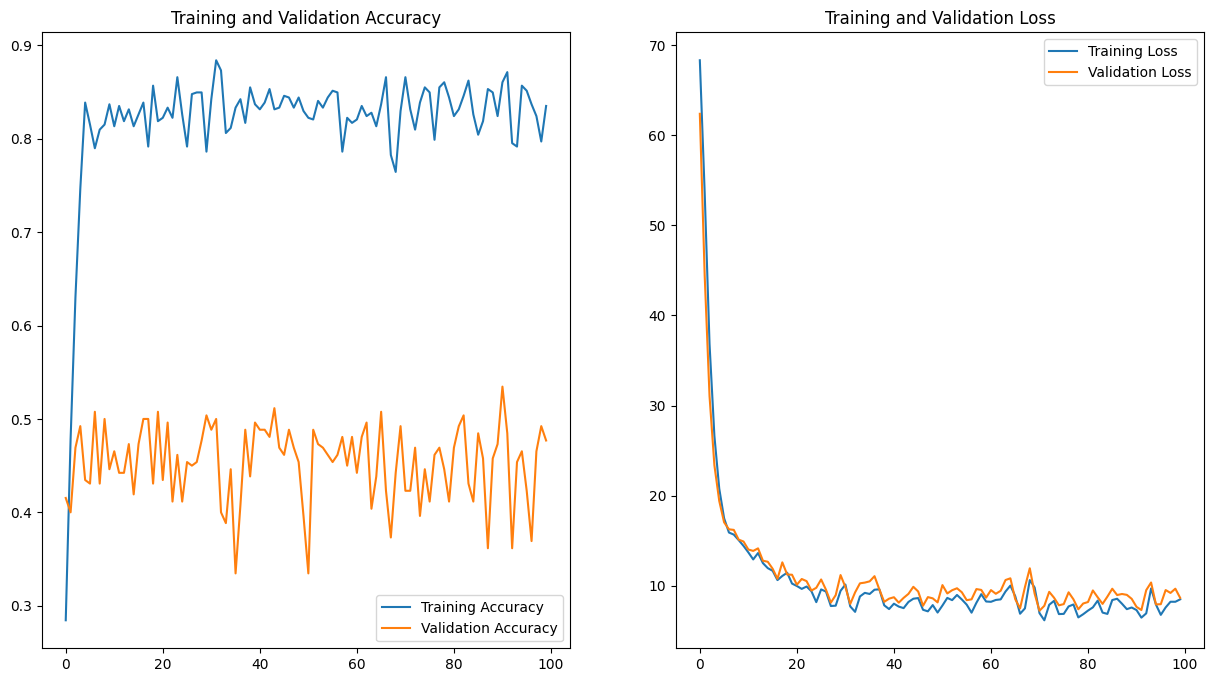

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [95]:
# Evaluate model on the test set
test_metrics = model.evaluate(valid_ds)
print(f"Test Loss: {test_metrics[0]}, \nTest Accuracy: {test_metrics[1]}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4802 - loss: 8.6894
Test Loss: 8.656929016113281, 
Test Accuracy: 0.4769230782985687


In [96]:
print(os.getcwd())


e:\projectDL\deepLearn-ANN


In [101]:
test_path = "test_image_rumah1lantai.jpg"


def prepare_image(image_path):
    # Define the target image size
    IMG_SIZE = (128, 128)
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE) 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, ksize=(3, 3), sigmaX=1) 

    #Apply Canny Edge 
    v = np.median(blurred)
    sigma = 0.33
    lower = int(max(50, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    aperture_size = 3
    img_edge = cv2.Canny(blurred,lower,upper,apertureSize=aperture_size,L2gradient=True)

    img_edge = img_edge / 255.0  # Normalisasi ke rentang [0,1]
    img_edge = np.stack((img_edge,) * 3, axis=-1)
    img_edge = np.expand_dims(img_edge, axis=0)  # Tambahkan dimensi batch
    return img_edge


test_image = prepare_image(test_path)

# Make a prediction
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions[0]) # Assuming a classification task

            # Customize based on your class labels
class_labels = ["Apartment","Penthouse","Ruko","Rumah 1 Lantai"]
building_class = class_labels[predicted_class]
confidence  = predictions[0][predicted_class] * 100
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(building_class,np.max(confidence))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This image most likely belongs to Ruko with a 60.21 percent confidence.


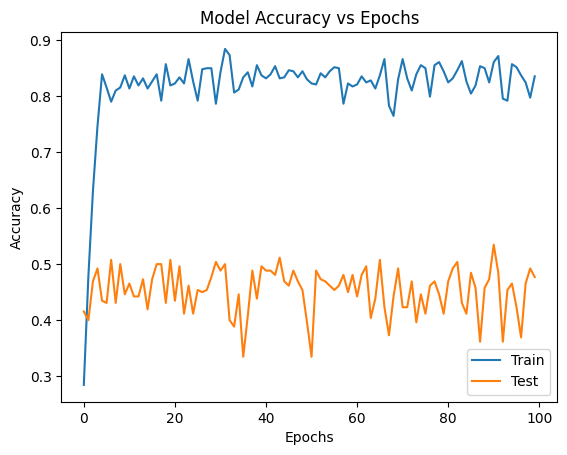

In [102]:
#Visualization Accuracy 
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

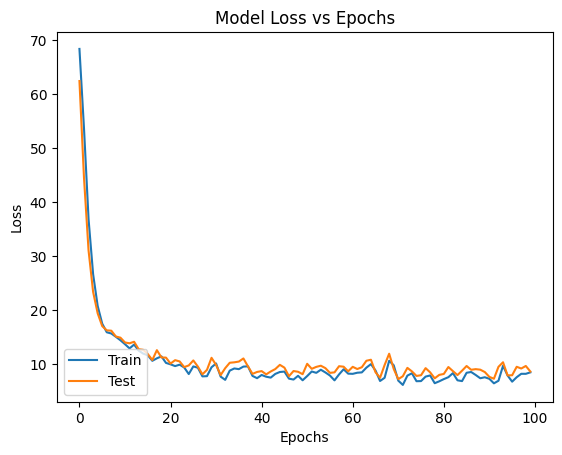

In [103]:
#Visualization Loss 
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Test'], loc='lower left')
plt.show()

In [104]:
from tensorflow.keras.models import load_model

#Save model for deployment

model.save("ann_model.h5")

In [106]:
!move /Y ann_model.h5 flask/static/models/

        1 file(s) moved.


### Define ANN Model Without Keras Module

In [12]:
def relu(x): 
  return np.maximum(0,x)

def relu_derivative(x): #Derivative of ReLU activation
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # To prevent overflow
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def categorical_crossentropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

In [13]:
#Reuse the variables 
print(X_images.shape) #Flattened Array (note the array has been normalized its pixels)
print(label_onehot.shape) #One Hot encoded consisted of 4 columns

(224, 110592)
(224, 4)


In [24]:
#ANN Structure
input_size = X_images.shape[1]  #Equivalent of input_shape example (150528,)
hidden_size = 192 #Number of neurons in hidden layer
output_size = y.shape[1] #Desired output (4 classes)

#Initialize Random weights and bias
w_hidden = np.random.randn(input_size,hidden_size) 
w_output = np.random.randn(hidden_size,output_size)

learning_rate = 0.001


In [25]:
epochs = 80
error_history= []

for i in range(epochs):
#Forward pass through hidden layer
  z1 = np.dot(X_images,w_hidden)
  a1 = relu(z1)

  #Forward pass through output layer
  z2 = np.dot(a1, w_output)
  a2 = softmax(z2)
  #Make equivalent that hidden_input = z1, hidden_output = a1
  #final_input = z2, final_output = a2

  #Count Loss with Categorical Crossentropy (multi class classification)
  loss = categorical_crossentropy(label_onehot, a2)
  error_history.append(loss)

  #Backpropagation
  delta_a2 = a2 - label_onehot #delta_a2 = a2 - Y
  delta_z2 = delta_a2 * a2 * (1-a2)

  # Compute gradients for the hidden layer
  delta_a1 = np.dot(delta_z2, w_output.T) 
  delta_z1 = delta_a1 * relu_derivative(z1)  # Derivative of ReLU

  #Define derivative weights
  d_w_output = np.dot(a1.T, delta_z2)  / label_onehot.size
  d_w_hidden = np.dot(X_images.T, delta_z1) / label_onehot.size

  # Update weights using gradient descent
  w_hidden -= learning_rate * d_w_hidden
  w_output -= learning_rate * d_w_output

  if (i + 1) % 10 == 0:
        print(f'Epoch: {i + 1}, Loss: {loss}')
        
print(f"Final loss history: {error_history[0]:.4f}")



Epoch: 10, Loss: 23.724693118630732
Epoch: 20, Loss: 23.723487657685194
Epoch: 30, Loss: 23.722298976234185
Epoch: 40, Loss: 23.72116199712328
Epoch: 50, Loss: 23.720066554474215
Epoch: 60, Loss: 23.718996597256712
Epoch: 70, Loss: 23.717940741688274
Epoch: 80, Loss: 23.716892200465686
Final loss history: 23.7257


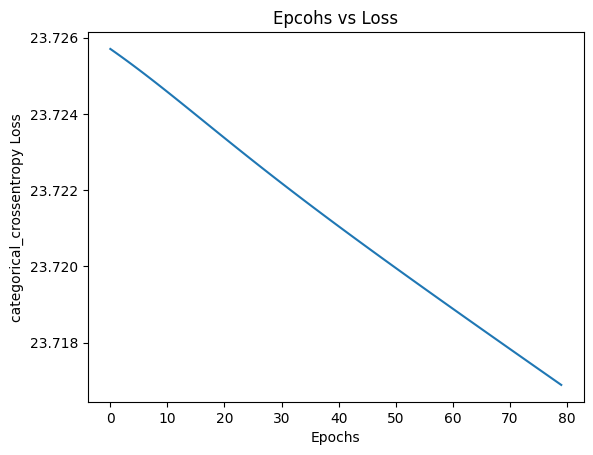

In [26]:
plt.plot(error_history)
plt.xlabel("Epochs")
plt.ylabel("categorical_crossentropy Loss")
plt.title("Epcohs vs Loss")
plt.show()